In [1]:
# All the dependancies 

%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, EllipticalAperture

import pandas as pd 

# for images too (also will use mpl)
import fitsio
from astropy.io import fits
#import sys 
import numpy.ma as ma
from gPhoton.reference import eclipse_to_paths
from gPhoton.coadd import zero_flag_and_edge


In [19]:
# Functions for Plotting Ellipses and Clipping Rasters 

# clipping 
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

def plot_centiles(array, upper_bounds):
    
    figures, axes = [], []
    
    for upper_bound in (upper_bounds):
        fig, ax = plt.subplots()
        ax.imshow(centile_clip(cnt, centiles=(0, upper_bound)))
        ax.set_title(str(upper_bound))
        figures.append(fig), axes.append(ax)
        
    return figures, axes

# ---------------------------------------------------------------------------------------------------------------
# converting hx and hy to distances in the x and y direction based on if the ratio (hx_hy_ratio) is less than or 
# greater than 1. 

# b is base size in pixels (or, what minimum size would you want your circle to be if b was the radius)

# x is the distance in the x direction, y is the distance in the y direction. depending on which is greater, x and 
# y will determine the semi major and minor axes of the ellipse. 

# if hx_hy_ratio > 1 then x = b * hx_hy_ratio and y = b (so x is hx_hy_ratio bigger than y)
# if hx_hy_ratio < 1 then x = b and y = b * (hx_hy_ratio)**-1

# function below to calculate x and y 

def calc_x(ratio, base_size): 
    if ratio > 1: 
        x = base_size * ratio 
        
    elif ratio <= 1: 
        x = base_size 
        
    return x

def calc_y(ratio, base_size): 
    if ratio < 1: 
        y = base_size * ratio**-1
        
    elif ratio >= 1: 
        y = base_size 
        
    return y

# function for editing pandas df to add geom info

def ellipse_info(name,run):
    # adding new column to sources that uses roundedness2 (R2) to calculate the ratio between hx and hy, the height of the 
    # best fitting gaussian to the marginal x or y axis distribution of the unconvulved source data. 
    # original roundedness2 equation: 2*(hx-hy/(hx+hy) = R2
    # ratio calculation derived from above: hx/hy = (2+R2)/(2-R2)
    
    if "px" in run: 
        if "100px" in run: 
            base_size = 100
        if "20px" in run: 
            base_size = 20
        if "50px" in run: 
            base_size = 50
    else: 
        base_size = 6
            
    name["hx_hy_ratio"] = (2 + name["roundness2"]) / (2 - name["roundness2"])

    # adding x and y lengths based on hx_hy ratio, theta (ellipse orientation) 
    #depending on longest length 
    name['x_len'] = name.apply(lambda name: calc_x(name['hx_hy_ratio'], base_size), axis=1)
    name['y_len'] = name.apply(lambda name: calc_y(name['hx_hy_ratio'], base_size), axis=1)
    name['theta'] = name['hx_hy_ratio'].apply(lambda x: 0 if x <= 1  else (np.pi/2))
    
    name['run'] = run
    return name

In [40]:
# reading in the image for the eclipse 

# info 
eclipse, band, depth, compression = 8045, "NUV", 30, "rice"
 
# FILL THIS IN, minus the file extension 

# HAS TO BE MORE THAN ONE FILE 
#list_files = ("23456_sources","23456_sources_45th","23456_sources_45x")  # 23456 (the og image)
list_files = ("8045_sources_45th","8045_sources_45th_r8","8045_sources_0th_r8") # the galaxy N3C300 from proposal
#list_files = ("8045_sources_0th_r8_50px","8045_sources_0th_r8_50px_50bx","8045_sources_0th_r8_50px_200bx")

# for drawing circles of source locations 
base_size = 6 # min size in pixels of output when a circle (aka the semiminor axis)

In [25]:
# reading in images 
galex_file_paths = eclipse_to_paths(
    eclipse, '/home/bekah/gphoton_working/test_data', depth, compression
)

# image to hdul 
%time hdul = fitsio.FITS(galex_file_paths[band]['image'])
%time cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]

# masking cnt image
masked_cnt = zero_flag_and_edge(cnt, flag, edge)

CPU times: user 126 µs, sys: 25 µs, total: 151 µs
Wall time: 158 µs
CPU times: user 133 ms, sys: 52.3 ms, total: 185 ms
Wall time: 183 ms


In [26]:
for name in list_files: 
    print (name)

8045_sources_0th_r8_50px
8045_sources_0th_r8_50px_50bx


In [41]:
# iterating through input files to turn into pd df and calculating geom variables for elliptical aperture input

allSourceRuns = []

for name in list_files: 
    file = pd.read_csv(f"{name}.csv")
    print(f"for the run {name}, the number of sources found is {len(file)}")
    
    df_changed = ellipse_info(file,name)
    
    allSourceRuns.append(df_changed)

allSourceRuns = pd.concat(allSourceRuns,ignore_index=True)

for the run 8045_sources_45th, the number of sources found is 4035
for the run 8045_sources_45th_r8, the number of sources found is 4081
for the run 8045_sources_0th_r8, the number of sources found is 3882


<IPython.core.display.Javascript object>


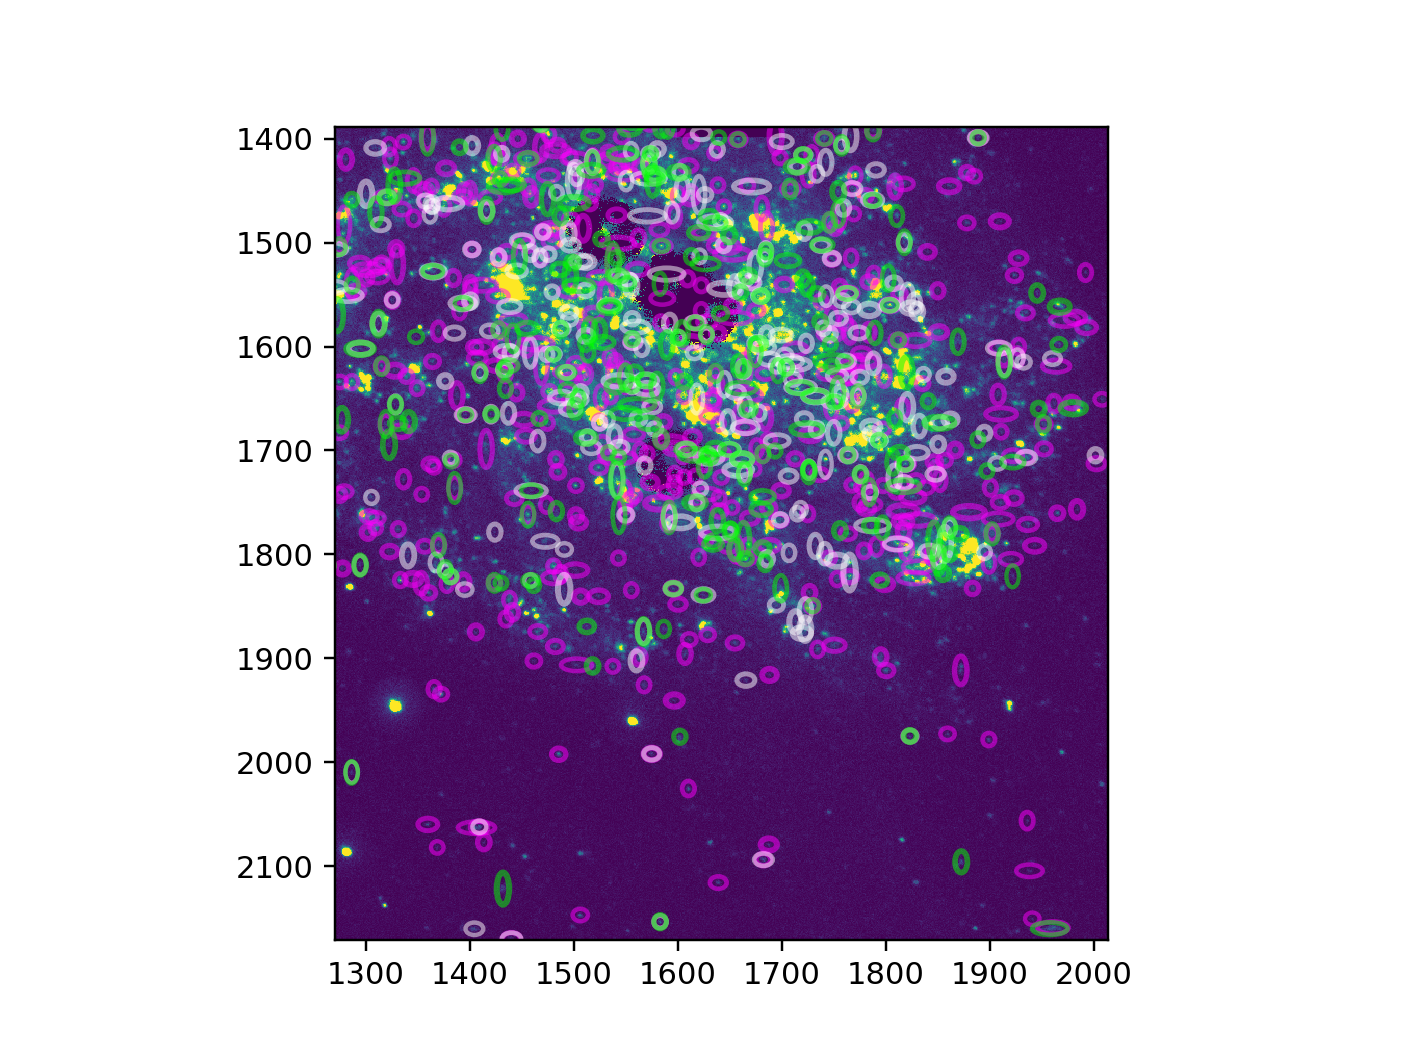

The color of run 8045_sources_45th is fuchsia.
The color of run 8045_sources_45th_r8 is white.
The color of run 8045_sources_0th_r8 is lime.


In [45]:
# plotting 

plt.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')

color_counter = 0 
color_list = ("fuchsia","white","lime","blue")


positions = np.transpose((allSourceRuns['xcentroid'], allSourceRuns['ycentroid']))

for n in range(len(list_files)): 
    color = color_list[n]
    print(f"The color of run {list_files[n]} is {color}.")
    
for i in range(len(allSourceRuns)): 
        aperture = EllipticalAperture(positions[i], 
                    a=max(allSourceRuns.loc[i,'x_len'],allSourceRuns.loc[i,'y_len']), 
                    b=min(allSourceRuns.loc[i,'x_len'],allSourceRuns.loc[i,'y_len']),
                    theta = allSourceRuns.loc[i,'theta'])
        if allSourceRuns.loc[i,'sharpness']>0.7:
            plt.show(aperture.plot(color=color_list[list_files.index(allSourceRuns.loc[i,'run'])], lw=allSourceRuns.loc[i,'sharpness']*2, alpha=0.5))